In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import numpy as np
from astropy.table import Table
from Ska.Matplotlib import plot_cxctime, cxctime2plotdate
from Chandra.Time import DateTime
from kadi import events
from mica.starcheck import get_starcheck_catalog
from Ska.engarchive import fetch

In [3]:
def get_obs_table():
    """
    Make a data table of obsids with MS filter status, one shot magnitudes, and att errors
    """
    dwells = events.dwells.filter(start='2015:287:12:22:55.309')
    mstable = Table.read('/data/aca/archive/pcad8/mstable.hd5', format='hdf5')
    obs_data = []
    for d in dwells:
        obs = {}
        obsid = d.get_obsid()
        if obsid is None:
            continue
        if DateTime(d.stop).secs > mstable['TIME'][-1]:
            continue
        # Get one shot and maneuver to for *next* obsid
        n = d.get_next()
        if not n:
            continue
        starcheck = get_starcheck_catalog(n.get_obsid())
        if not starcheck or not len(starcheck['manvr']):
            continue
        obs['manvr_angle'] = starcheck['manvr'][-1]['angle_deg']
        obs['manvr_slew_err'] =  starcheck['manvr'][-1]['slew_err_arcsec']
        obs['next_obsid'] = n.get_obsid()

        obs['date'] = d.manvr.kalman_start
        obs['datestop'] = d.stop
        obs['time'] = DateTime(d.manvr.kalman_start).secs
        obs['timestop'] = d.tstop
        obs['one_shot'] = n.manvr.one_shot
        obs['obsid'] = obsid

        # for data earlier than the chunk of pcad data I have
        # just set the status manually (though I did check that these have the flag set
        # correctly)
        if d.manvr.kalman_start < '2016:001':
            if (obsid == 17198) or (obsid == 18718):
                obs['gui_ms'] = 'DISA'
            else:
                obs['gui_ms'] = 'ENAB'
        else:
            mid_kalman = ((DateTime(d.manvr.kalman_start).secs
                            + DateTime(d.stop).secs) / 2)
            kal_idx = (np.searchsorted(mstable['TIME'],
                                        mid_kalman))
            obs['gui_ms'] = mstable['AOACIMSS'][kal_idx]

        for err_name, err_msid in zip(['roll_err', 'pitch_err', 'yaw_err'],
                                        ['AOATTER1', 'AOATTER2', 'AOATTER3']):
            err = fetch.Msid(err_msid, d.tstart + 500, d.stop)
            events.dumps.interval_pad = (0, 300)
            err.remove_intervals(events.dumps)
            if len(err.vals):
                obs[err_name] = np.degrees(np.percentile(np.abs(err.vals), 90)) * 3600
            else:
                obs[err_name] = np.nan

        obs_data.append(obs)

    t = Table(obs_data)['obsid', 'next_obsid', 'time', 'timestop', 'date', 'datestop',
                        'gui_ms', 'manvr_angle', 'manvr_slew_err', 'one_shot',
                        'roll_err', 'pitch_err', 'yaw_err']
    return t

In [4]:
#t = get_obs_table()
#t.write('obs_ms_table.dat', format='ascii')

In [5]:
t = Table.read('obs_ms_table.dat', format='ascii')
msd = t['gui_ms'] == 'DISA'
print DateTime(t['time'][-1]).date

2016:104:04:52:30.687


In [6]:
def one_shot_plot(t, label=None, min_dwell_time=1000):
    t = t[(t['timestop'] - t['time']) >= min_dwell_time]
    msd = t['gui_ms'] == 'DISA'
    figure(figsize(7, 5))
    plot(t['manvr_angle'][~msd], t['one_shot'][~msd], 'b+', markersize=5, markeredgewidth=.8,
        label='last dwell MSF ENAB')
    plot(t['manvr_angle'][msd], t['one_shot'][msd], 'rx', markersize=5, markeredgewidth=.8,
         label='last dwell MSF DISA')
    grid()
    xlim(0, 185)
    ylim(-1, 80)
    ylabel('One Shot (arcsec)')
    xlabel('Manvr Angle (deg)')
    legend(loc='upper left', fontsize=10, numpoints=1, handletextpad=0)
    title('One Shot Magnitude ({})'.format(label), fontsize=12)
    tight_layout()

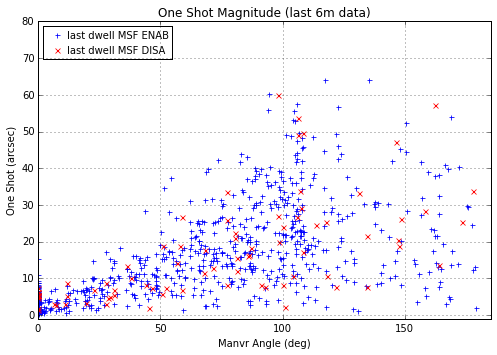

In [7]:
one_shot_plot(t, 'last 6m data')

Plot above: One shots of last 6 months of data

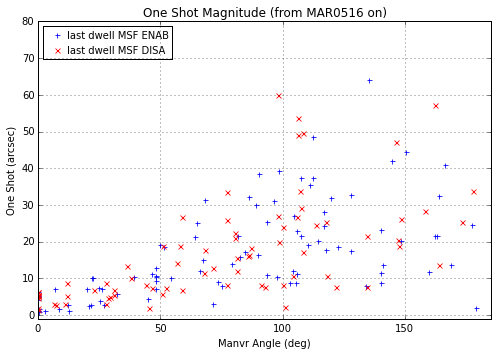

In [8]:
# select observations at and after 51213 (beginning of MAR0516 schedule)
recent = t[t['time'] >= t[t['obsid'] == 51213]['time']]
one_shot_plot(recent, 'from MAR0516 on')

Plot above: One shots of data since beginning of MAR0516 schedule

In [9]:
def att_err_time_plots(t, min_dwell_time=1000):
    t = t[(t['timestop'] - t['time']) >= min_dwell_time]
    msd = t['gui_ms'] == 'DISA'
    for i, ax in enumerate(['roll', 'pitch', 'yaw'], 1):
        figure(figsize(7, 5))
        plot_cxctime(t['time'][~msd], t['{}_err'.format(ax)][~msd], 'b+', markersize=5,
                     label='MSF ENAB')
        plot_cxctime(t['time'][msd], t['{}_err'.format(ax)][msd], 'rx', markersize=5,
                     label='MSF DISA')
        title('90th percentile {} error (AOATTER{}) magnitude (per obs)'.format(ax, i),
              fontsize=12)
        grid()
        ylabel('{} err (arcsec)'.format(ax))
        legend(loc='upper left', fontsize=10, numpoints=1)
        margins(.1)
        tight_layout()
        #for obs in t:
        #    text(cxctime2plotdate([obs['time']])[0], obs['{}_err'.format(ax)], obs['obsid'])

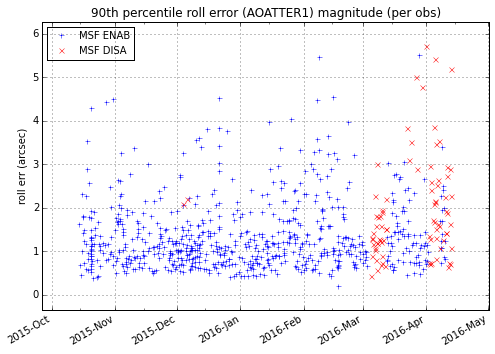

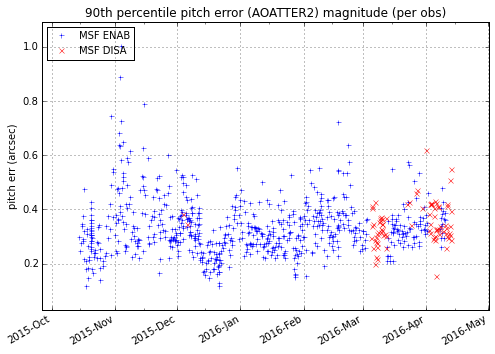

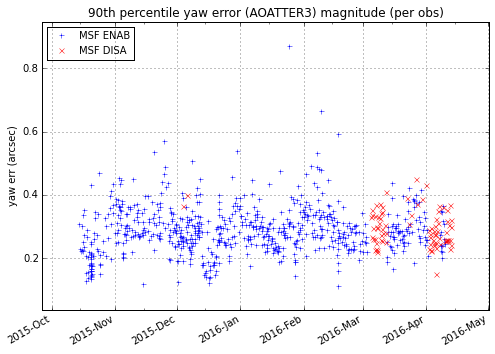

In [10]:
att_err_time_plots(t)

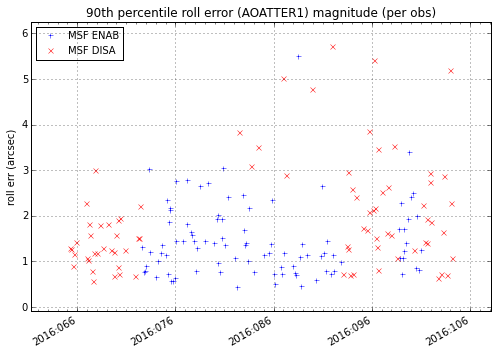

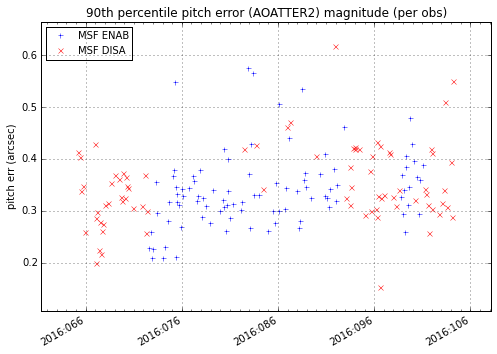

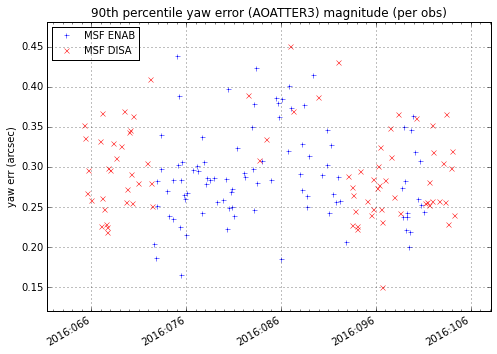

In [11]:
att_err_time_plots(recent)

In [12]:
def att_err_plots(t, label=None, min_dwell_time=1000, scale_norm=False):
    t = t[(t['timestop'] - t['time']) >= min_dwell_time]
    msd = t['gui_ms'] == 'DISA'
    for i, ax in enumerate(['roll', 'pitch', 'yaw'], 1):
        figure(figsize(9, 3.5))
        lim = 1.5
        if ax == 'roll':
            lim = 10
        bins = np.arange(0, lim, .1)
        ax1 = subplot(1, 2, 1)
        h1 = hist(t['{}_err'.format(ax)][~msd], bins=bins, log=True, color='b',
             alpha=.4, label='MSF ENAB')
        ylim(.5)
        ylims = ylim()
        if scale_norm:
            ylabel('N obs', color='b')
            ax1p5 = ax1.twinx()
        h2 = hist(t['{}_err'.format(ax)][msd], bins=bins, log=True, color='r',
             alpha=.4, label='MSF DISA')
        title('90th percentile {} error (AOATTER{}) magnitude (per obs)'.format(ax, i),
              fontsize=8)
        xlabel('{} err (arcsec)'.format(ax))
        if scale_norm:
            # scale the right axis to have the peak of the  MS disabled data match the
            # corresponding point on the all-data histogram
            idx_max = np.argmax(h1[0])
            min_h1 = .5
            yrange = log10(ylims[1]) - log10(ylims[0])
            all_data_range = log10(h1[0][idx_max]) - log10(ylims[0])
            ratio = all_data_range / yrange
            msf_data_range = log10(h2[0][idx_max]) - log10(min_h1)
            mymax = (msf_data_range / ratio) + log10(min_h1)
            ylim(min_h1, 10**mymax)

            p1, l1 = ax1.get_legend_handles_labels()
            p2, l2 = ax1p5.get_legend_handles_labels()
            for tl in ax1.get_yticklabels():
                tl.set_color('b')
            for tl in ax1p5.get_yticklabels():
                tl.set_color('r')
            ylabel('MSF N obs', color='r', rotation=270)
            legend(p1 + p2, l1 + l2, loc='upper right', fontsize=8)
        else:
            legend(loc='upper right', fontsize=8)
            
        ax2 = subplot(1, 2, 2)
        plot_cxctime(t['time'][~msd], t['{}_err'.format(ax)][~msd], 'b+', markersize=3,
                     label='MSF ENAB')
        plot_cxctime(t['time'][msd], t['{}_err'.format(ax)][msd], 'rx', markersize=3,
                     label='MSF DISA')
        title('90th percentile {} error (AOATTER{}) magnitude (per obs)'.format(ax, i),
              fontsize=8)
        grid()
        ylabel('{} err (arcsec)'.format(ax))
        legend(loc='upper left', fontsize=8, numpoints=1)
        ylim(0, lim) 
        margins(.1)
        tight_layout()
        subplots_adjust(wspace=.3)


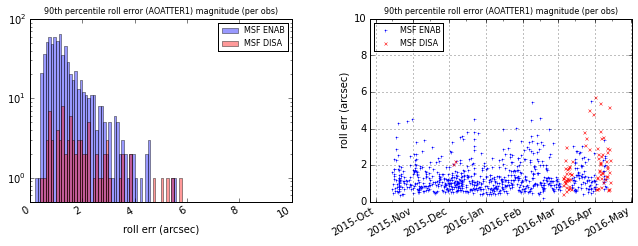

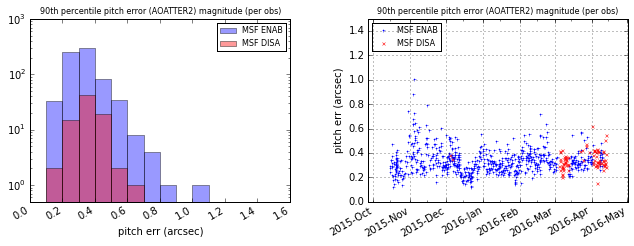

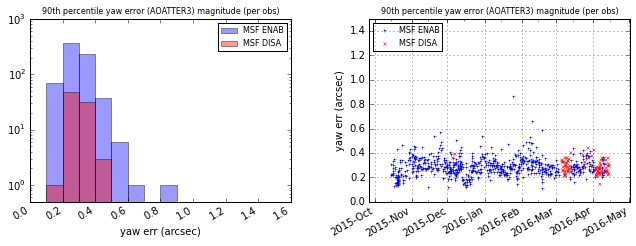

In [13]:
att_err_plots(t)

Above: Attitude errors of last 6 months of data with observations with MSF disabled (full duration) marked in red

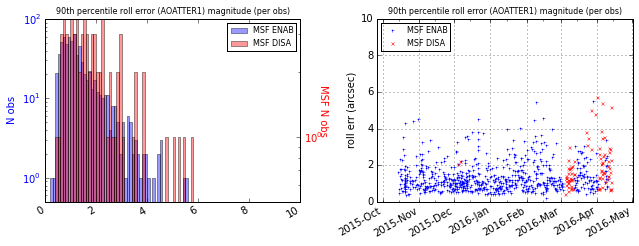

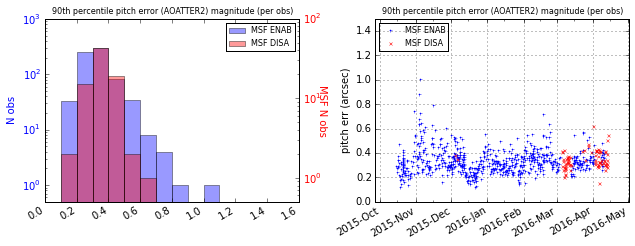

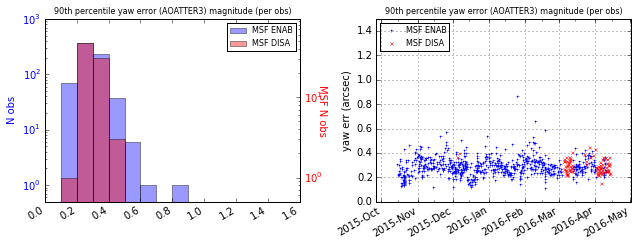

In [14]:
att_err_plots(t, scale_norm=True)

Above: Attitude errors of last 6 months of data with the MSF disabled axis scaled such that the
peaks of the MSF enabled and MSF disabled data match (though it looks like the scaling is not perfect on the roll plot).

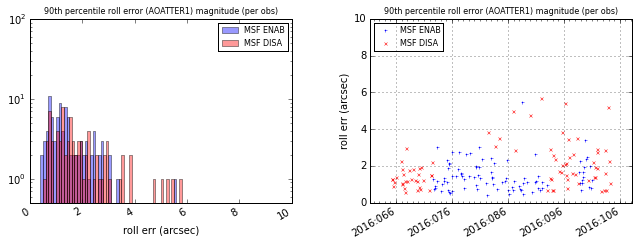

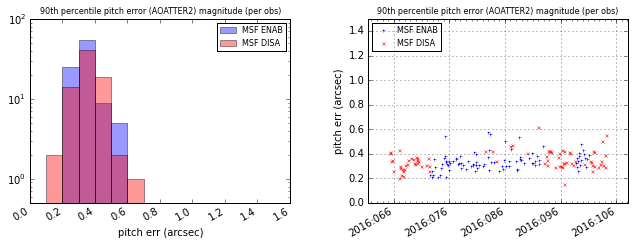

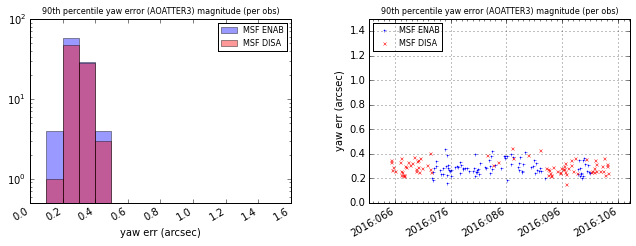

In [15]:
att_err_plots(recent)

Above: Attitude errors data beginning with MAR0516 schedule with observations with MSF disabled (full duration) marked in red

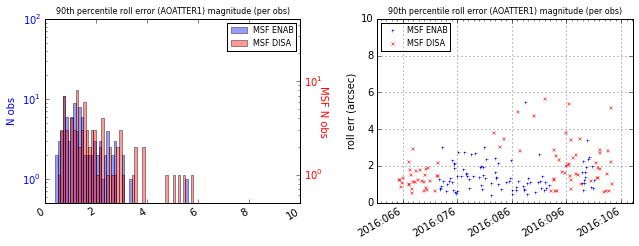

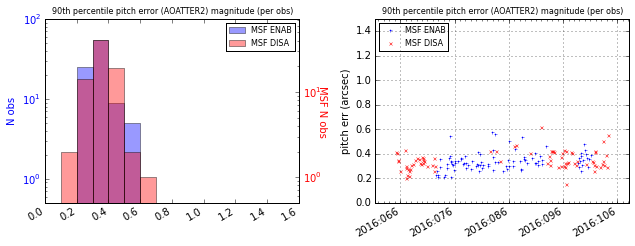

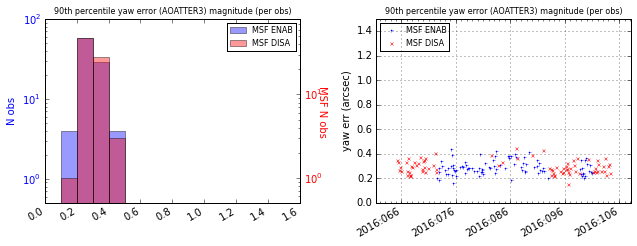

In [16]:
att_err_plots(recent, scale_norm=True)

Above: Attitude errors data beginning with MAR0516 schedule with the MSF disabled axis scaled such that the
peaks of the MSF enabled and MSF disabled data match.